### DTML MODEL
```
사용 데이터 출처 : github.com/fulifeng/Adv-ALSTM
```

In [1]:
import matplotlib.pyplot as plt
import os
import shutil
import zipfile
import glob
import cv2
import tensorflow as tf
import numpy as np
import pandas as pd
import random
import pydot
import graphviz
# import pydotplus
import warnings

In [2]:
from functools import partial
from itertools import product
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import matthews_corrcoef
from sklearn.utils import class_weight

In [3]:
from tensorflow.keras.layers import Layer
import tensorflow.keras.backend as K

In [4]:
#%%Seed 설정 (중요)
tf.random.set_seed(2022)
np.random.seed(2022)

### dir

In [5]:
root_dir = 'C:/Users/begas/'

### custom call back

In [6]:
class PrinterCallback(tf.keras.callbacks.Callback):

    # def on_train_batch_begin(self, batch, logs=None):
    #     # Do something on begin of training batch

    def on_epoch_end(self, epoch, logs=None):
        print('EPOCH: {}, Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'.format(epoch,
                                                                                            logs['loss'],
                                                                                            logs['accuracy'],               
                                                                                            logs['val_loss'],
                                                                                            logs['val_accuracy']))

    def on_epoch_begin(self, epoch, logs=None):
        print('-'*50)
        print('STARTING EPOCH: {} / Learning Rate: {}'.format(epoch,round(float(tf.keras.backend.get_value(self.model.optimizer.lr)),7)))
  
        
    # def on_train_batch_end(self, batch, logs=None):
    #     # Do something on end of training batch
    #

In [7]:
nStocks = 50

In [8]:
# ===================================================================================================================
# Model Tune Grid
# ===================================================================================================================
param_grid = {
    "bUseInitialState"   : [False],
    "bHiddenConcat"      : [True],
    "nStocks"            : [nStocks] ,
    "nTimeSteps"         : [10],
    "nFeatures"          : [11],
    "bFeatureTransShare" : [True],
    "nFeatureTransUnits" : [32],
    "nGruHiddenUnits"    : [64],
    "nMcBeta"            : [0.01,0.1,1],
    "nMultiHeads"        : [16],
    "nMlpMultiples"      : [4],
    "bLayerNormal"       : [True],
    "nDropOutRate"       : [0.1],
    "nRegularizers"      : [1],
    "sOptimizer"         : ['Adam'],
    "nLearningRate"      : [0.001],
    "nMaxEpoch"          : [200],
    "nPatience"          : [20],
    "nBatchSize"         : [32] ,
    "bTimeDistributed"   : [False],
    "bAddContextLayer"   : [False]
}

tune_grid = pd.DataFrame(ParameterGrid(param_grid))
tune_grid = tune_grid[list(param_grid.keys())]
tune_grid

,bUseInitialState,bHiddenConcat,nStocks,nTimeSteps,nFeatures,bFeatureTransShare,nFeatureTransUnits,nGruHiddenUnits,nMcBeta,nMultiHeads,...,bLayerNormal,nDropOutRate,nRegularizers,sOptimizer,nLearningRate,nMaxEpoch,nPatience,nBatchSize,bTimeDistributed,bAddContextLayer
0,False,True,50,10,11,True,32,64,0.01,16,...,True,0.1,1,Adam,0.001,200,20,32,False,False
1,False,True,50,10,11,True,32,64,0.10,16,...,True,0.1,1,Adam,0.001,200,20,32,False,False
2,False,True,50,10,11,True,32,64,1.00,16,...,True,0.1,1,Adam,0.001,200,20,32,False,False


In [9]:
class model():
    
    def __init__(self, nStocks, nTimeSteps, nFeatures, bFeatureTransShare, nFeatureTransUnits 
                     , bUseInitialState, nGruHiddenUnits, bHiddenConcat, nMcBeta, nMultiHeads
                     , bAddContextLayer, nMlpMultiples, bLayerNormal, nDropOutRate, nRegularizers
                     , sOptimizer, nLearningRate, bTimeDistributed) :
        
        # -- Input Layer
        self.nStocks            = nStocks            # Input 주식 수
        self.nTimeSteps         = nTimeSteps         # Input 타임스텝 수
        self.nFeatures          = nFeatures          # Input 피쳐 개수
        
        # -- Feature Transformtion Layer
        self.bFeatureTransShare = bFeatureTransShare # FeatureTrans 레이어 공유 여부
        self.nFeatureTransUnits = nFeatureTransUnits # Transformation Layer Units 개수
        
        # -- GRU Layer
        self.bUseInitialState   = bUseInitialState   # GRU Initial Hidden State 지정 사용 여부
        self.nGruHiddenUnits    = nGruHiddenUnits    # Gru 히든 개수
        
        # -- Time - Axis Context Layer
        self.bHiddenConcat      = bHiddenConcat      # Context Vector와 Last Hidden layer Concat 여부
           
        # -- Multi - Level Context Layer
        self.nMcBeta            = nMcBeta            # Multi Level Context 지수 반영 정도
        
        # -- Multi - Head Attention Layer
        self.nMultiHeads        = nMultiHeads        # Multi Head Attention 파라미터
        
        # -- Nonlinear Transformtion Layer
        self.bAddContextLayer   = bAddContextLayer   # Add Context Layer, Attention Layer : H + H'
        self.nMlpMultiples      = nMlpMultiples      # MLP Layer에서 Gru Hidden Units의 몇배수 만큼 변화시킬 것인지
        self.bLayerNormal       = bLayerNormal       # Layer Normalization 적용 여부
        self.nDropOutRate       = nDropOutRate       # Drop Out Rate
        
        # -- Final Prediction Layer
        self.nRegularizers      = nRegularizers      # Regularizer parameters
        self.sOptimizer         = sOptimizer         # Optimizer 종류 'Adam' , 'RMSprop'
        self.nLearningRate      = nLearningRate      # Optimizer Learning Rate
        self.bTimeDistributed   = bTimeDistributed   # TImeDistributed 사용 여부
           
        # build
        self._build()
        
        # compile
        self._compile()
                
    def _build(self) :

        # ===================================================================================================================
        # Market TIme - Axis
        # ===================================================================================================================
        
        # Market Input
        market_input_layer = tf.keras.Input(shape = (self.nTimeSteps,self.nFeatures), name = "market_input")
        market_feature_trans_layer = tf.keras.layers.Dense(self.nFeatureTransUnits, activation="tanh", name = "market_feature_trans")(market_input_layer)
        
        # HIdden State, Last Hidden State 추출
        if self.bUseInitialState == True : 
            market_initial_state = tf.keras.layers.GRU(self.nGruHiddenUnits, return_state=True, name = 'market_initial_state')(market_feature_trans_layer)[1]
            market_hidden_states, market_last_hidden_state = tf.keras.layers.GRU(self.nGruHiddenUnits,return_sequences = True, return_state=True, name = 'market_hidden')(market_feature_trans_layer,initial_state = market_initial_state)
        else :
            market_hidden_states, market_last_hidden_state = tf.keras.layers.GRU(self.nGruHiddenUnits,return_sequences = True, return_state=True, name = 'market_hidden')(market_feature_trans_layer)
       
        # Attention Score 계산
        market_attention_score_layer = tf.nn.softmax(tf.keras.layers.dot([market_hidden_states,market_last_hidden_state], axes=[2,1]), name = 'market_attention_score')
        market_attention_score_reshape_layer = tf.keras.layers.Reshape((1,self.nTimeSteps),name = 'market_attention_reshape')(market_attention_score_layer)

        # Market Context Vector 생성 -> Gru Hidden State * Attention Score
        market_context_layer = tf.keras.layers.Lambda(lambda x : tf.matmul(x[0],x[1]),name = 'market_hidden_dot_attention')([market_attention_score_reshape_layer,market_hidden_states])
        
        # MarKet Context Vector + Last Hidden State
        if self.bHiddenConcat == True :
            market_last_hidden_state_reshape = tf.keras.layers.Reshape((1,self.nGruHiddenUnits),name = 'market_last_hidden_reshape')(market_last_hidden_state)
            market_context_layer = tf.keras.layers.concatenate([market_context_layer,market_last_hidden_state_reshape],name = f'market_hidden_concat')
         
        # Market Context Layer Stack(개별 주식 Context와 합치기 위해 형태 변경)
        market_context_layer = tf.keras.layers.concatenate([market_context_layer for _ in range(self.nStocks)],name = f'market_context_concat',axis = 1)

        # ===================================================================================================================
        # Stock TIme - Axis
        # ===================================================================================================================
        
        if self.bFeatureTransShare == True :
            stock_transform_layer = tf.keras.layers.Dense(self.nFeatureTransUnits, activation="tanh", name = "stock_feature_trans")

        stock_context_layer_list = []

        for stock_idx in range(self.nStocks) :
            
            if self.bFeatureTransShare == False :
                stock_transform_layer = tf.keras.layers.Dense(self.nFeatureTransUnits, activation="tanh", name = f"{stock_idx}_stock_feature_trans")
                
            tmp_layer_list = []

            # Individual Stock Input
            tmp_layer_list.append(tf.keras.Input(shape = (self.nTimeSteps,self.nFeatures), name = f"{stock_idx}_stock_input"))

            # Feature Transformation
            tmp_layer_list.append(stock_transform_layer(tmp_layer_list[0]))

            # HIdden State, Last Hidden State 추출
            if self.bUseInitialState == True :
                # initial state
                initial_state_layers = \
                tf.keras.layers.GRU(self.nGruHiddenUnits, return_state=True, name = f'{stock_idx}_stock_initial_state')(tmp_layer_list[1])[1]
                tmp_layer_list.append(tf.keras.layers.GRU(self.nGruHiddenUnits, return_sequences = True, return_state=True
                                                                              , name = f"{stock_idx}_stock_hidden")(tmp_layer_list[1],initial_state = initial_state_layers))
            else :
                tmp_layer_list.append(tf.keras.layers.GRU(self.nGruHiddenUnits, return_sequences = True, return_state=True
                                                                              , name = f"{stock_idx}_stock_hidden")(tmp_layer_list[1]))
            
            # Attention Score 계산    
            tmp_layer_list.append(tf.nn.softmax(tf.keras.layers.dot([tmp_layer_list[2][0],tmp_layer_list[2][1]], axes=[2,1])
                                                                , name = f'{stock_idx}_attention_score'))
            tmp_layer_list.append(tf.keras.layers.Reshape((1,self.nTimeSteps),name = f'{stock_idx}th_attention_reshape')(tmp_layer_list[3]))

            # Individual Stock Context Vector 생성 -> Gru Hidden State * Attention Score
            tmp_layer_list.append(tf.keras.layers.Lambda(lambda x :  tf.matmul(x[0],x[1]),name = f'{stock_idx}_hidden_dot_attention')([tmp_layer_list[4], tmp_layer_list[2][0]]))
            
            # Individual Stock Context Vector + Last Hidden State
            if self.bHiddenConcat == True :
                stock_last_hidden_state_reshape = tf.keras.layers.Reshape((1,self.nGruHiddenUnits),name = f'{stock_idx}_last_hidden_reshape')(tmp_layer_list[2][1])
                tmp_layer_list.append(tf.keras.layers.concatenate([tmp_layer_list[5],stock_last_hidden_state_reshape],name = f'{stock_idx}_hidden_concat'))
             
            # List Append
            stock_context_layer_list.append(tmp_layer_list)
            del(tmp_layer_list)

        # Individual Stock Context Normalization    
        stock_attention_concat_layer = tf.keras.layers.concatenate([stock_context_layer_list[s][-1] for s in range(self.nStocks)],name = f'all_stock_attention_reshape_concat',axis = 1)
        stock_attention_concat_layer = tf.keras.layers.LayerNormalization(axis = (1,2),name = 'context_normalization')(stock_attention_concat_layer)
        
        # ===================================================================================================================
        # Multi Level Context
        # ===================================================================================================================
        
        # Multi Level Context(hyperparameters : nMcBeta)
        multi_level_context_layer =\
        tf.keras.layers.Lambda(lambda x : x[0] + (x[1] * self.nMcBeta),name = f'multi_level_context')([stock_attention_concat_layer, market_context_layer])
       
        # ===================================================================================================================
        # Multi Head Attention
        # ===================================================================================================================
        
        # Multi head Attention Layer
        multi_head_attention_layer , attention_score_layers = \
        tf.keras.layers.MultiHeadAttention(num_heads=self.nMultiHeads, key_dim=int(self.nGruHiddenUnits/self.nMultiHeads),name = 'multi_head_attention')(multi_level_context_layer,multi_level_context_layer, return_attention_scores=True)

        # ===================================================================================================================
        # Non - Liniear Transformation
        # ===================================================================================================================
        
        # Add Context Layer, Attention Layer : H + H'
        if self.bAddContextLayer == True:
            add_mc_mha_layers = \
            tf.keras.layers.add([multi_level_context_layer,multi_head_attention_layer], name = 'add_mc_mha')

            # MLP layers
            mlp_layer = tf.keras.layers.Dense(add_mc_mha_layers.shape[2] * self.nMlpMultiples, activation = 'relu',name = 'mlp_0')(add_mc_mha_layers)
            mlp_layer = tf.keras.layers.Dense(add_mc_mha_layers.shape[2], name = 'mlp_1')(mlp_layer)

            # Non-linear Transformation layers
            non_linear_transform_layer = tf.nn.tanh(tf.keras.layers.add([add_mc_mha_layers,mlp_layer],name = 'non_linear_transform'))
            if self.bLayerNormal == True :
                non_linear_transform_layer = tf.keras.layers.LayerNormalization()(non_linear_transform_layer)
            non_linear_transform_layer = tf.keras.layers.Dropout(self.nDropOutRate)(non_linear_transform_layer)
        
        else :
            add_mc_mha_layers = \
            tf.keras.layers.concatenate([multi_level_context_layer,multi_head_attention_layer], name = 'add_mc_mha')

            # MLP layers
            mlp_layer = tf.keras.layers.Dense(add_mc_mha_layers.shape[2] * self.nMlpMultiples, activation = 'relu',name = 'mlp_0')(add_mc_mha_layers)
            mlp_layer = tf.keras.layers.Dense(add_mc_mha_layers.shape[2], name = 'mlp_1')(mlp_layer)

            # Non-linear Transformation layers
            non_linear_transform_layer = tf.nn.tanh(tf.keras.layers.concatenate([add_mc_mha_layers,mlp_layer],name = 'non_linear_transform'))
            
            # Normalization
            if self.bLayerNormal == True :
                non_linear_transform_layer = tf.keras.layers.LayerNormalization()(non_linear_transform_layer)
            
            # Dropout
            non_linear_transform_layer = tf.keras.layers.Dropout(self.nDropOutRate)(non_linear_transform_layer)

        # ===================================================================================================================
        # FInal Prediction Layer
        # ===================================================================================================================
        
        if self.bTimeDistributed == False :
        
            output_layer = \
            tf.keras.layers.Dense(1, activation ='sigmoid',
                                  kernel_regularizer = tf.keras.regularizers.l2(l=self.nRegularizers),
                                  kernel_initializer = tf.keras.initializers.orthogonal(seed = 1234), 
                                  name = 'output')(non_linear_transform_layer)
        else :
            
            output_layer = \
            tf.keras.layers.TimeDistributed(
            tf.keras.layers.Dense(1, activation ='sigmoid',
                                  kernel_regularizer = tf.keras.regularizers.l2(l=self.nRegularizers),
                                  kernel_initializer = tf.keras.initializers.orthogonal(seed = 1234), 
                                  name = 'output')
            )(non_linear_transform_layer)
        
        
        # Model Build
        smc_model_input = [market_input_layer] + [stock_context_layer_list[s][0] for s in range(len(stock_context_layer_list))]
        smc_model_output = output_layer
        
        # Final Model
        self.smc_model = tf.keras.Model(inputs = smc_model_input, outputs = smc_model_output)
        
    
    def _compile(self):

        # Optimizer
        if self.sOptimizer == "Adam":
            optim = tf.keras.optimizers.Adam(learning_rate = self.nLearningRate)
        if self.sOptimizer == "RMSprop":
            optim = tf.keras.optimizers.RMSprop(learning_rate = self.nLearningRate)

        # Compile   
        self.smc_model.compile(optimizer = optim, loss = 'binary_crossentropy',metrics=['accuracy'])

## 데이터 생성

In [10]:
from pandas_datareader import data as pdr
import seaborn as sns

In [11]:
def create_dataset(df, window_size, target_name):
    x_data = []
    y_data = []
    
    for i in range(window_size, len(df)):
        tmp_x = df[(i - window_size):i].drop(columns=target_name)
        tmp_y = df[(i - window_size):i][target_name].iloc[-1]
        
        x_data.append(tmp_x)
        y_data.append(tmp_y)
    
    x_data = np.array(x_data)
    y_data = np.array(y_data).reshape(len(y_data),1)
    
    return x_data, y_data

In [12]:
window_size = 10    # {10, 15}

In [13]:
X_TRAIN = []
Y_TRAIN = []
X_VALID = []
Y_VALID = []
X_TEST = []
Y_TEST = []

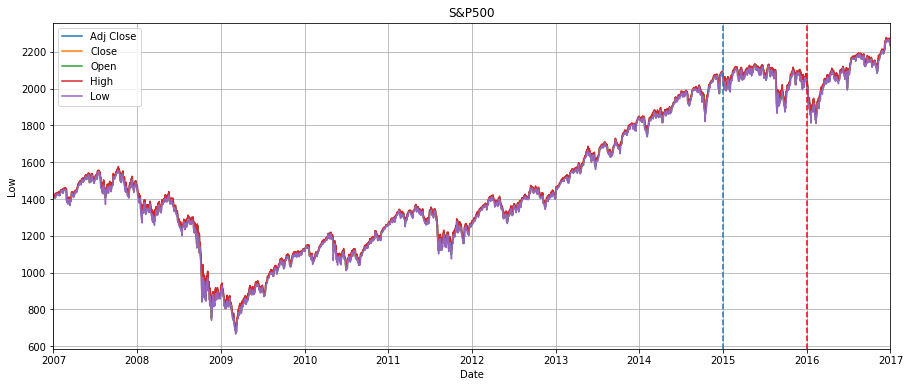

[Market] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


In [14]:
# ===========================================================
# Market Data
# ===========================================================
raw_data = pdr.DataReader('^GSPC', data_source='yahoo', start='2007-01-03', end='2016-12-30')
raw_data.sort_index(inplace=True)

# Train / Valid / Test 기간 그림 그리기
fig, ax = plt.subplots(figsize=(15, 6))

sns.lineplot(data=raw_data, x=raw_data.index, y='Adj Close', ax=ax, label = 'Adj Close')
sns.lineplot(data=raw_data, x=raw_data.index, y='Close', ax=ax, label = 'Close')
sns.lineplot(data=raw_data, x=raw_data.index, y='Open', ax=ax, label = 'Open')
sns.lineplot(data=raw_data, x=raw_data.index, y='High', ax=ax, label = 'High')
sns.lineplot(data=raw_data, x=raw_data.index, y='Low', ax=ax, label = 'Low')

ax.grid()
ax.set_title("S&P500")
ax.set_xlim(pd.to_datetime('2007-01-01'),pd.to_datetime('2017-01-01'))
ax.axvline(pd.to_datetime('2015-01-01'),linestyle = '--')
ax.axvline(pd.to_datetime('2016-01-01'),linestyle = '--', color = 'red')
plt.show()

ana_data = raw_data.copy()

del ana_data['Volume']

ana_data['Open'] = ana_data['Open']/ana_data['Close'] - 1
ana_data['High'] = ana_data['High']/ana_data['Close'] - 1
ana_data['Low'] = ana_data['Low']/ana_data['Close'] - 1
ana_data['Close'] = ana_data['Close'].pct_change()
ana_data['d_05'] = ana_data['Adj Close'].shift(1).rolling(5).sum()/(ana_data['Adj Close'] * 5) - 1
ana_data['d_10'] = ana_data['Adj Close'].shift(1).rolling(10).sum()/(ana_data['Adj Close'] * 10) - 1
ana_data['d_15'] = ana_data['Adj Close'].shift(1).rolling(15).sum()/(ana_data['Adj Close'] * 15) - 1
ana_data['d_20'] = ana_data['Adj Close'].shift(1).rolling(20).sum()/(ana_data['Adj Close'] * 20) - 1
ana_data['d_25'] = ana_data['Adj Close'].shift(1).rolling(25).sum()/(ana_data['Adj Close'] * 25) - 1
ana_data['d_30'] = ana_data['Adj Close'].shift(1).rolling(30).sum()/(ana_data['Adj Close'] * 30) - 1
ana_data['Adj Close'] = ana_data['Adj Close'].pct_change()  # 순서 바꾸면 안됨.

ana_data['target'] = ana_data["Adj Close"].shift(-1) > 0
ana_data['target'] = ana_data['target'].astype(int)


ana_data = ana_data.dropna()

start = ana_data.index[0].strftime("%Y%m%d")
end = ana_data.index[-1].strftime("%Y%m%d")

ana_data = ana_data[(ana_data.index >= '2007-01-01') & (ana_data.index < '2017-01-01')]

ana_data_tr = ana_data[(ana_data.index >= '2007-01-01') & (ana_data.index < '2015-01-01')].copy()
ana_data_vl = ana_data[(ana_data.index >= '2015-01-01') & (ana_data.index < '2016-01-01')].copy()
ana_data_ts = ana_data[(ana_data.index >= '2016-01-01') & (ana_data.index < '2017-01-01')].copy()

x_train, y_train = create_dataset(ana_data_tr, window_size, target_name='target')
x_valid, y_valid = create_dataset(ana_data_vl, window_size, target_name='target')
x_test,  y_test  = create_dataset(ana_data_ts, window_size, target_name='target')

# Check Missing value
_trx = np.isnan(x_train).sum()
_try = np.isnan(y_train).sum()
_vax = np.isnan(x_valid).sum()
_vay = np.isnan(y_valid).sum()
_tex = np.isnan(x_test).sum()
_tey = np.isnan(y_test).sum()
print(f'[Market] / Start Date : {start} / End Date : {end} / Missing value {_trx}/{_try}/{_vax}/{_vay}/{_tex}/{_tey}')



# X_TRAIN.append(x_train[-1040:,:,:])
# Y_TRAIN.append(y_train[-1040:,:])
X_TRAIN.append(x_train)
Y_TRAIN.append(y_train)
X_VALID.append(x_valid)
Y_VALID.append(y_valid)
X_TEST.append(x_test)
Y_TEST.append(y_test)

In [15]:
# ===========================================================
# Stock Data
# ===========================================================
data_dir = 'DAT/data/kdd17/price_long_50'
stock_csv_file_list = os.listdir(os.path.join(root_dir,data_dir))
stock_dir_list = [os.path.join(root_dir,data_dir,s) for s in stock_csv_file_list]
stock_labels = [s.replace('.csv','') for s in stock_csv_file_list]

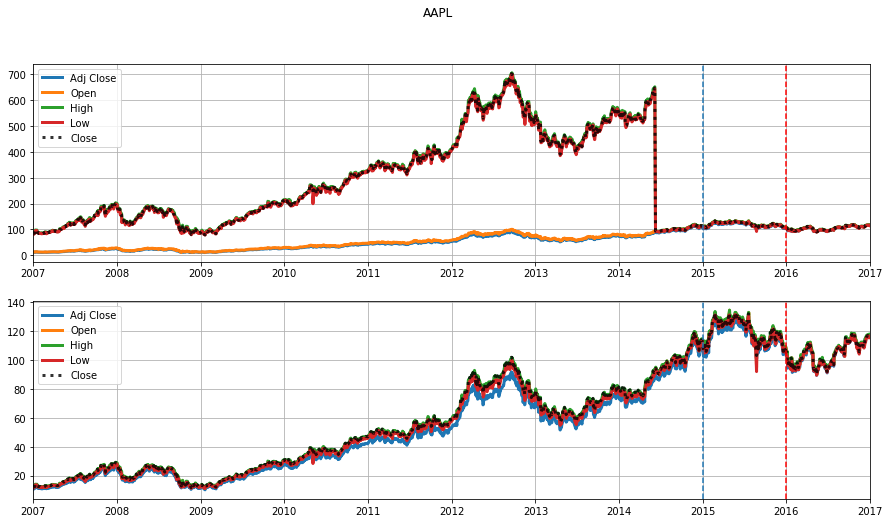

[AAPL] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[AMZN] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[BA] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


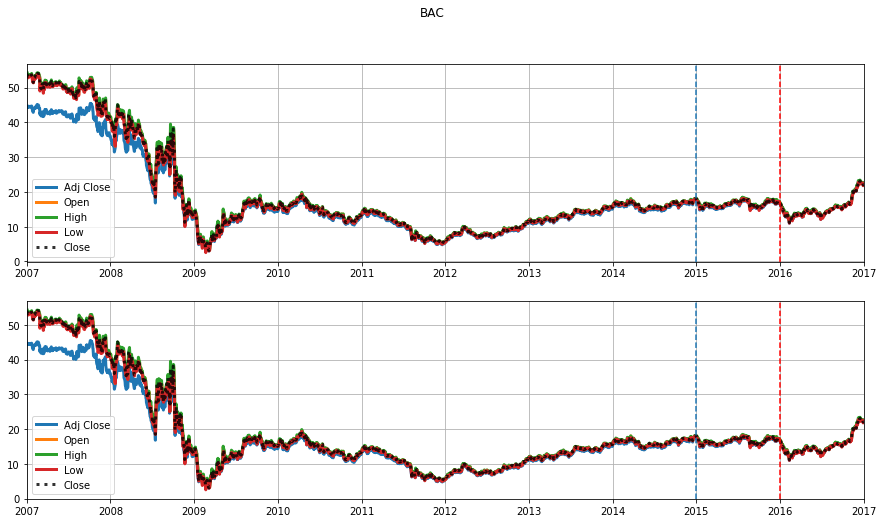

[BAC] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[BHP] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


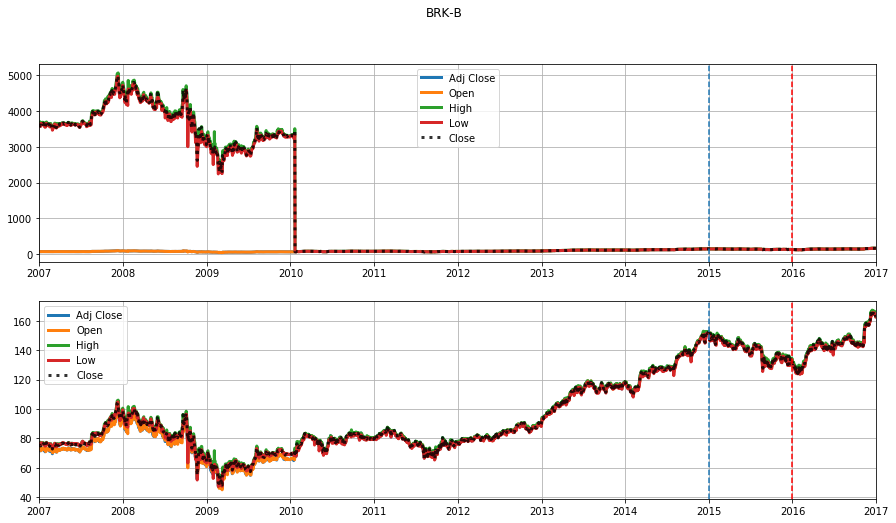

[BRK-B] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[CHL] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[CMCSA] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[CVX] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


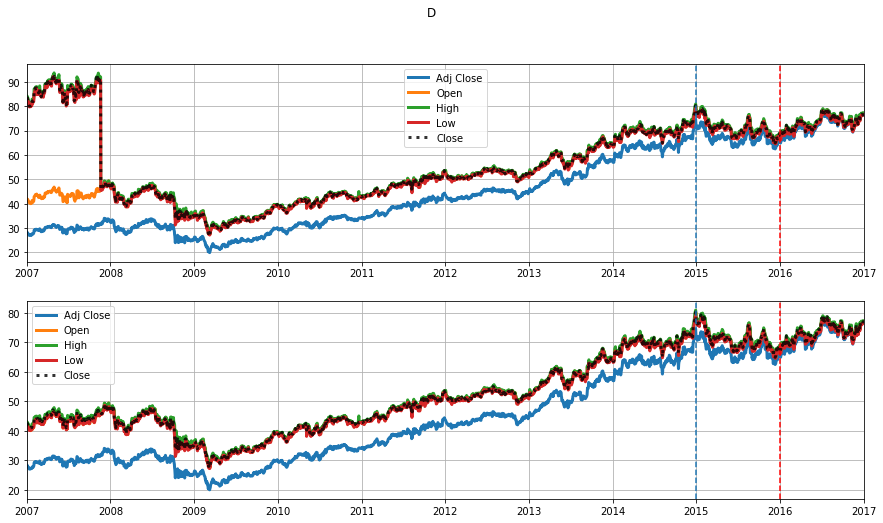

[D] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[DCM] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[DIS] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[DOW] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


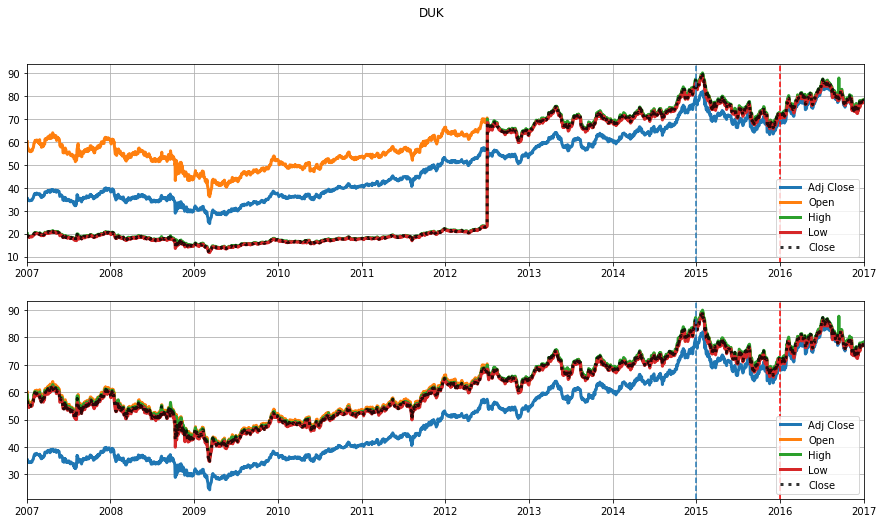

[DUK] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


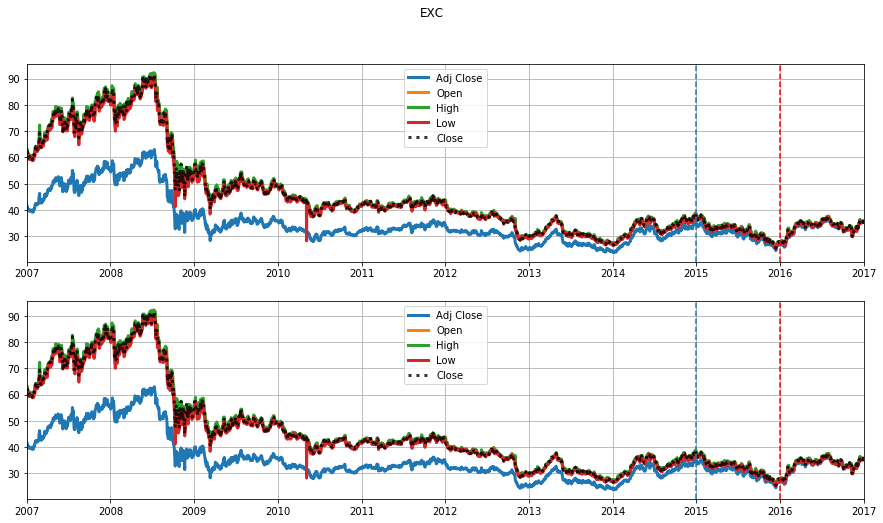

[EXC] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[GE] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


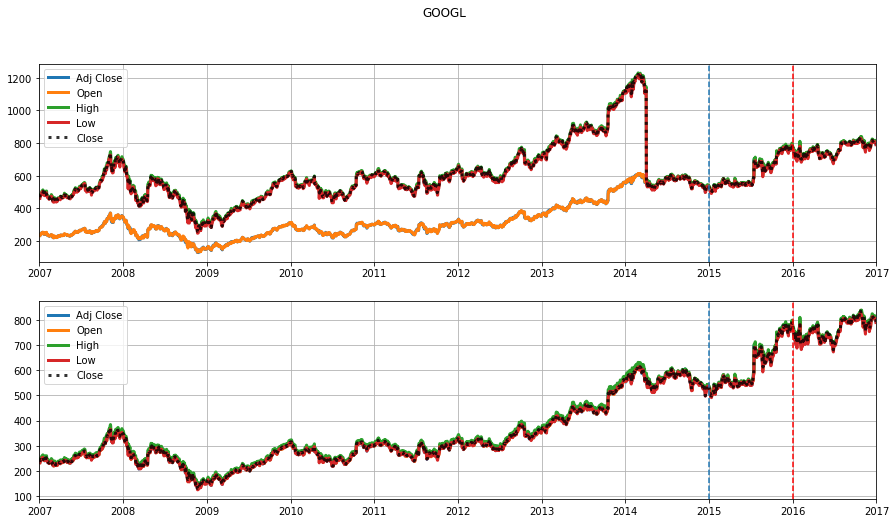

[GOOGL] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[HD] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[INTC] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[JNJ] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[JPM] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


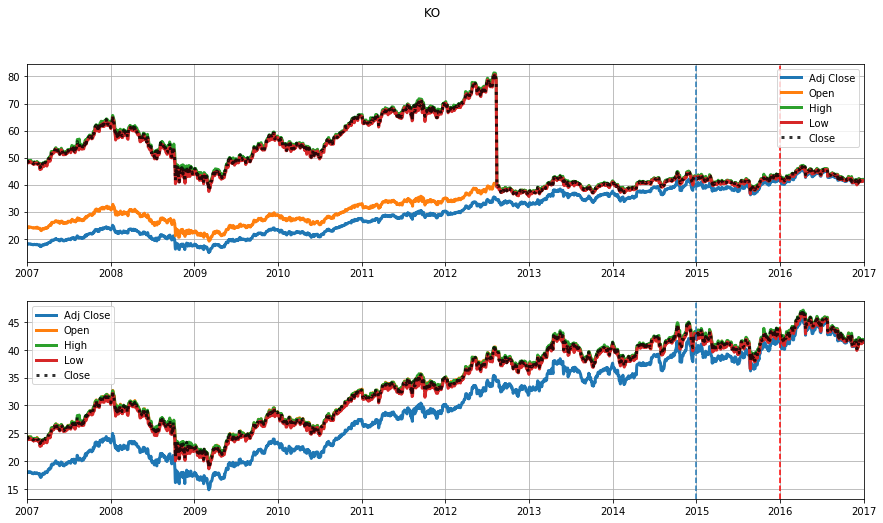

[KO] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


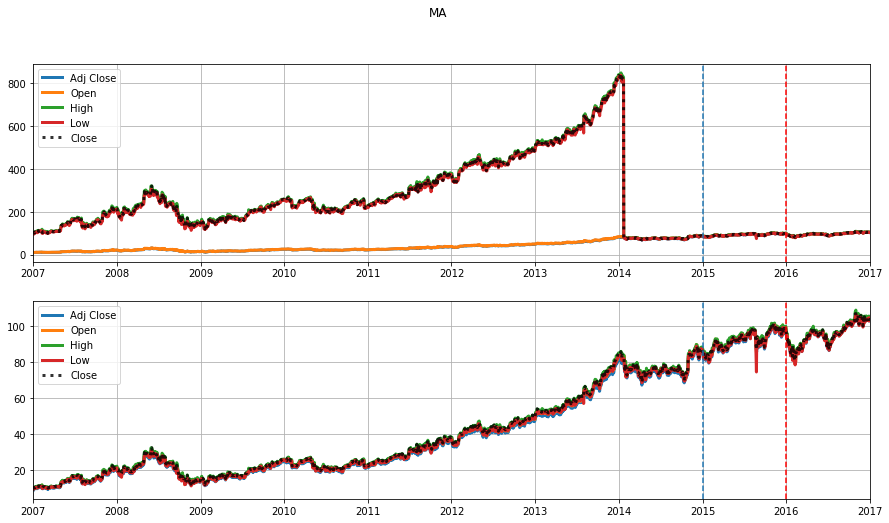

[MA] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[MMM] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


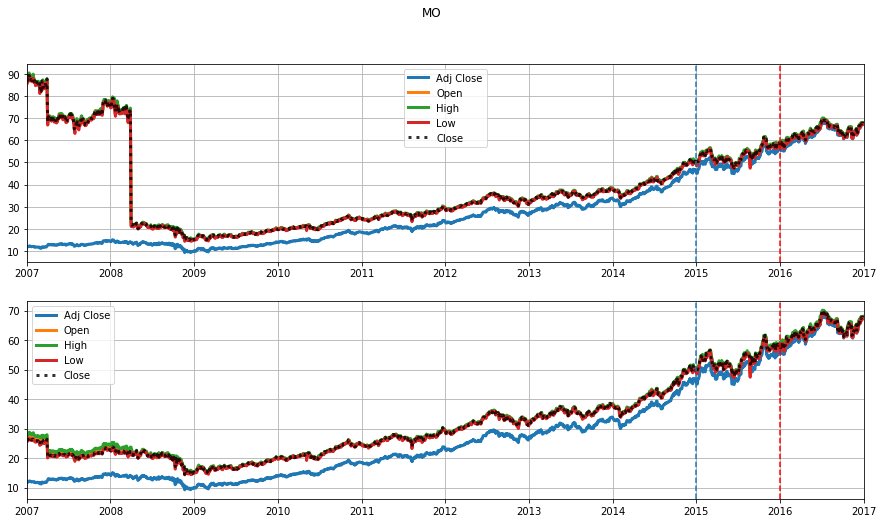

[MO] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[MRK] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[MSFT] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[NGG] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[NTT] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[NVS] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[ORCL] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[PEP] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[PFE] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


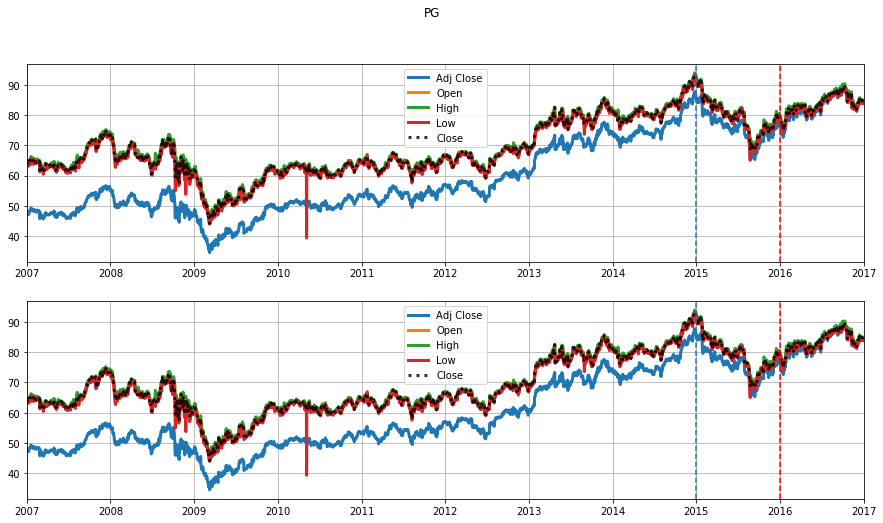

[PG] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[PTR] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[RDS-B] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


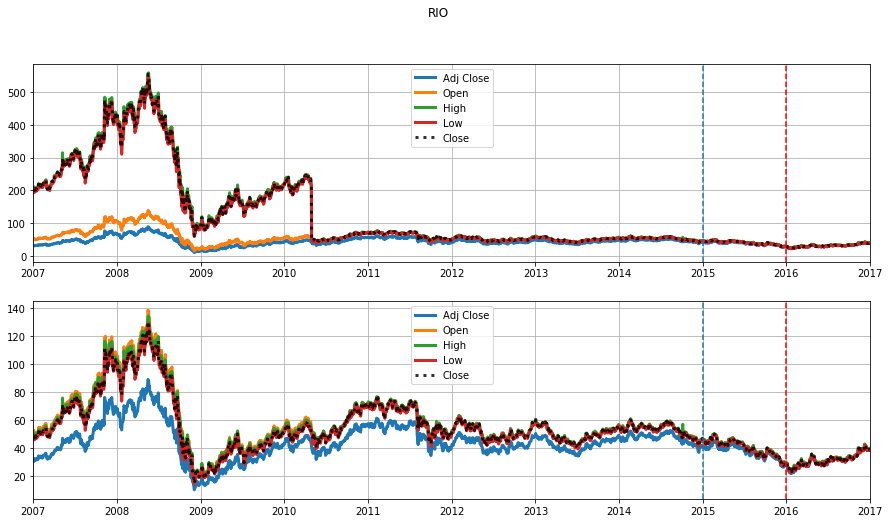

[RIO] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[SO] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[SPY] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[SYT] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[T] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[TM] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[TOT] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[UNH] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[UPS] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


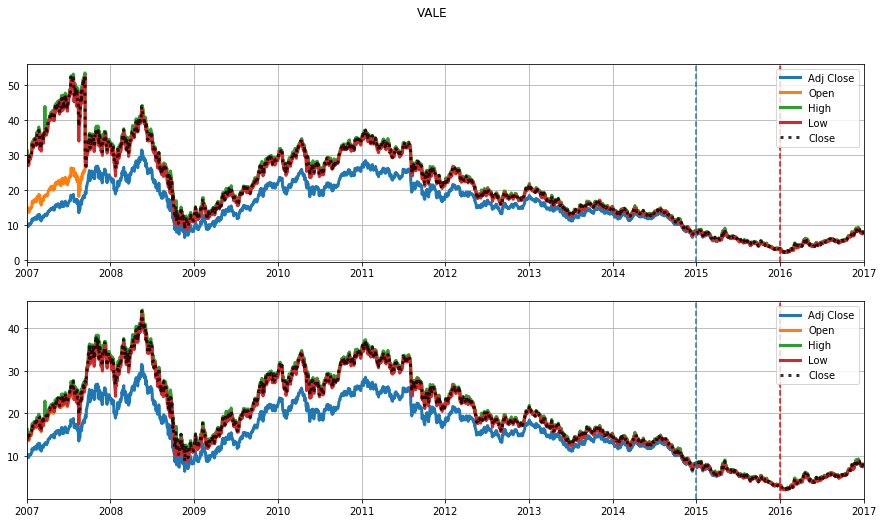

[VALE] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[VZ] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[WFC] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[WMT] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0
[XOM] / Start Date : 20070215 / End Date : 20161230 / Missing value 0/0/0/0/0/0


In [16]:
date_check_list = []
# for stock_idx in range(len(stock_dir_list)) :
for stock_idx in range(nStocks) :    
        
    raw_data = pd.read_csv(stock_dir_list[stock_idx], usecols=['Date','High','Low','Open','Close','Volume','Adj Close'])
    raw_data['Date'] = pd.to_datetime(raw_data['Date'])
    raw_data = raw_data.sort_values('Date').reset_index(drop = True)
    
    
    # 주식 분할 등 데이터 이상치 처리 S ========================================================================
    ana_data = raw_data.copy()
    cols = ['High','Low','Close','Open']
    tmp_ret_df = ana_data[cols].pct_change(1).abs()
    tmp_ret_df = (tmp_ret_df > 0.4)
#     tmp_ret_df = (tmp_ret_df - tmp_ret_df.quantile(0.9999)) > 0
    
    for col in cols :
        if tmp_ret_df[col].sum() == 0 :
            continue
        if stock_labels[stock_idx] in ['PG','BAC','EXC'] :
            continue

        # 데이터 이상 포인트 Check
        iloc = np.argwhere(tmp_ret_df[col].values).flatten()        
        if len(iloc) > 1 :
            print(f'Check Data Point{iloc}')

        # 누적할인 
        cum_prod = (ana_data[col][:iloc[0]].pct_change(1).fillna(0) + 1).cumprod()    
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            last_value = ana_data[col][iloc[0]]
            ana_data.loc[:,col][:iloc[0]] = ((cum_prod/cum_prod.values[-1]) * last_value).values
    # 주식 분할 등 데이터 이상치 처리 E ========================================================================

    # 데이터 처리한 경우 그래프 생성
    if tmp_ret_df.sum().sum() > 0 :
        
        # Train / Valid / Test 기간 그림 그리기
        fig, ax = plt.subplots(2,1,figsize=(15, 8))

        ax[0].plot(raw_data['Date'], raw_data['Adj Close'], label = 'Adj Close', linewidth = 3)
        ax[0].plot(raw_data['Date'], raw_data['Open'] , label = 'Open' , linewidth = 3)
        ax[0].plot(raw_data['Date'], raw_data['High'] , label = 'High' , linewidth = 3)
        ax[0].plot(raw_data['Date'], raw_data['Low']  , label = 'Low'  , linewidth = 3)
        ax[0].plot(raw_data['Date'], raw_data['Close'], label = 'Close', linewidth = 3,linestyle=':', color = 'black', alpha = 0.8)

        ax[0].legend()
        ax[0].grid()

        ax[0].set_xlim(pd.to_datetime('2007-01-01'),pd.to_datetime('2017-01-01'))
        ax[0].axvline(pd.to_datetime('2015-01-01'),linestyle = '--')
        ax[0].axvline(pd.to_datetime('2016-01-01'),linestyle = '--', color = 'red')


        ax[1].plot(ana_data['Date'], ana_data['Adj Close'], label = 'Adj Close', linewidth = 3)
        ax[1].plot(ana_data['Date'], ana_data['Open'] , label = 'Open' , linewidth = 3)
        ax[1].plot(ana_data['Date'], ana_data['High'] , label = 'High' , linewidth = 3)
        ax[1].plot(ana_data['Date'], ana_data['Low']  , label = 'Low'  , linewidth = 3)
        ax[1].plot(ana_data['Date'], ana_data['Close'], label = 'Close', linewidth = 3,linestyle=':', color = 'black', alpha = 0.8)

        ax[1].legend()
        ax[1].grid()

        ax[1].set_xlim(pd.to_datetime('2007-01-01'),pd.to_datetime('2017-01-01'))
        ax[1].axvline(pd.to_datetime('2015-01-01'),linestyle = '--')
        ax[1].axvline(pd.to_datetime('2016-01-01'),linestyle = '--', color = 'red')


        fig.suptitle(stock_labels[stock_idx])
        plt.show()
    

 
    
    
    del ana_data['Volume']

    ana_data['Open'] = ana_data['Open']/ana_data['Close'] - 1
    ana_data['High'] = ana_data['High']/ana_data['Close'] - 1
    ana_data['Low'] = ana_data['Low']/ana_data['Close'] - 1
    ana_data['Close'] = ana_data['Close'].pct_change()
    ana_data['d_05'] = ana_data['Adj Close'].shift(1).rolling(5).sum()/(ana_data['Adj Close'] * 5) - 1
    ana_data['d_10'] = ana_data['Adj Close'].shift(1).rolling(10).sum()/(ana_data['Adj Close'] * 10) - 1
    ana_data['d_15'] = ana_data['Adj Close'].shift(1).rolling(15).sum()/(ana_data['Adj Close'] * 15) - 1
    ana_data['d_20'] = ana_data['Adj Close'].shift(1).rolling(20).sum()/(ana_data['Adj Close'] * 20) - 1
    ana_data['d_25'] = ana_data['Adj Close'].shift(1).rolling(25).sum()/(ana_data['Adj Close'] * 25) - 1
    ana_data['d_30'] = ana_data['Adj Close'].shift(1).rolling(30).sum()/(ana_data['Adj Close'] * 30) - 1
    ana_data['Adj Close'] = ana_data['Adj Close'].pct_change()  # 순서 바꾸면 안됨.
    
    ana_data['target'] = ana_data["Adj Close"].shift(-1) > 0
    ana_data['target'] = ana_data['target'].astype(int)

    ana_data = ana_data.dropna().reset_index(drop = True)
    
    start = ana_data['Date'].iloc[0].strftime("%Y%m%d")
    end = ana_data['Date'].iloc[-1].strftime("%Y%m%d")
    
    ana_data = ana_data[(ana_data['Date'] >= '2007-01-01') & (ana_data['Date'] < '2017-01-01')]

    ana_data_tr = ana_data[(ana_data['Date'] >= '2007-01-01') & (ana_data['Date'] < '2015-01-01')].copy()
    ana_data_vl = ana_data[(ana_data['Date'] >= '2015-01-01') & (ana_data['Date'] < '2016-01-01')].copy()
    ana_data_ts = ana_data[(ana_data['Date'] >= '2016-01-01') & (ana_data['Date'] < '2017-01-01')].copy()

    x_train, y_train = create_dataset(ana_data_tr.iloc[:,1:], window_size, target_name='target')
    x_valid, y_valid = create_dataset(ana_data_vl.iloc[:,1:], window_size, target_name='target')
    x_test,  y_test  = create_dataset(ana_data_ts.iloc[:,1:], window_size, target_name='target')
    
    # Check Missing value
    _trx = np.isnan(x_train).sum()
    _try = np.isnan(y_train).sum()
    _vax = np.isnan(x_valid).sum()
    _vay = np.isnan(y_valid).sum()
    _tex = np.isnan(x_test).sum()
    _tey = np.isnan(y_test).sum()
    print(f'[{stock_labels[stock_idx]}] / Start Date : {start} / End Date : {end} / Missing value {_trx}/{_try}/{_vax}/{_vay}/{_tex}/{_tey}')

#     X_TRAIN.append(x_train[-1040:,:,:])
#     Y_TRAIN.append(y_train[-1040:,:])
    X_TRAIN.append(x_train)
    Y_TRAIN.append(y_train)
    X_VALID.append(x_valid)
    Y_VALID.append(y_valid)
    X_TEST.append(x_test)
    Y_TEST.append(y_test)
    date_check_list.append(pd.Series([stock_labels[stock_idx],start,end]).to_frame().T)

In [17]:
############################################
# Check Data Dim
############################################

print(f'X Train Data Dim : {set(([X_TRAIN[s].shape for s in range(len(X_TRAIN))]))}')
print(f'Y Train Data Dim : {set(([Y_TRAIN[s].shape for s in range(len(Y_TRAIN))]))}')

print(f'X Valid Data Dim : {set(([X_VALID[s].shape for s in range(len(X_VALID))]))}')
print(f'Y Valid Data Dim : {set(([Y_VALID[s].shape for s in range(len(Y_VALID))]))}')

print(f'X Test  Data Dim : {set(([X_TEST[s].shape for s in range(len(X_TEST))]))}')
print(f'Y Test  Data Dim : {set(([Y_TEST[s].shape for s in range(len(Y_TEST))]))}')


############################################
# 시장의 OUTPUT 제거
############################################
Model_Y_TRAIN = Y_TRAIN[1:]
Model_Y_VALID = Y_VALID[1:]
Model_Y_TEST = Y_TEST[1:]

X Train Data Dim : {(1974, 10, 11)}
Y Train Data Dim : {(1974, 1)}
X Valid Data Dim : {(242, 10, 11)}
Y Valid Data Dim : {(242, 1)}
X Test  Data Dim : {(242, 10, 11)}
Y Test  Data Dim : {(242, 1)}


### X 데이터 체크 (AAPL)

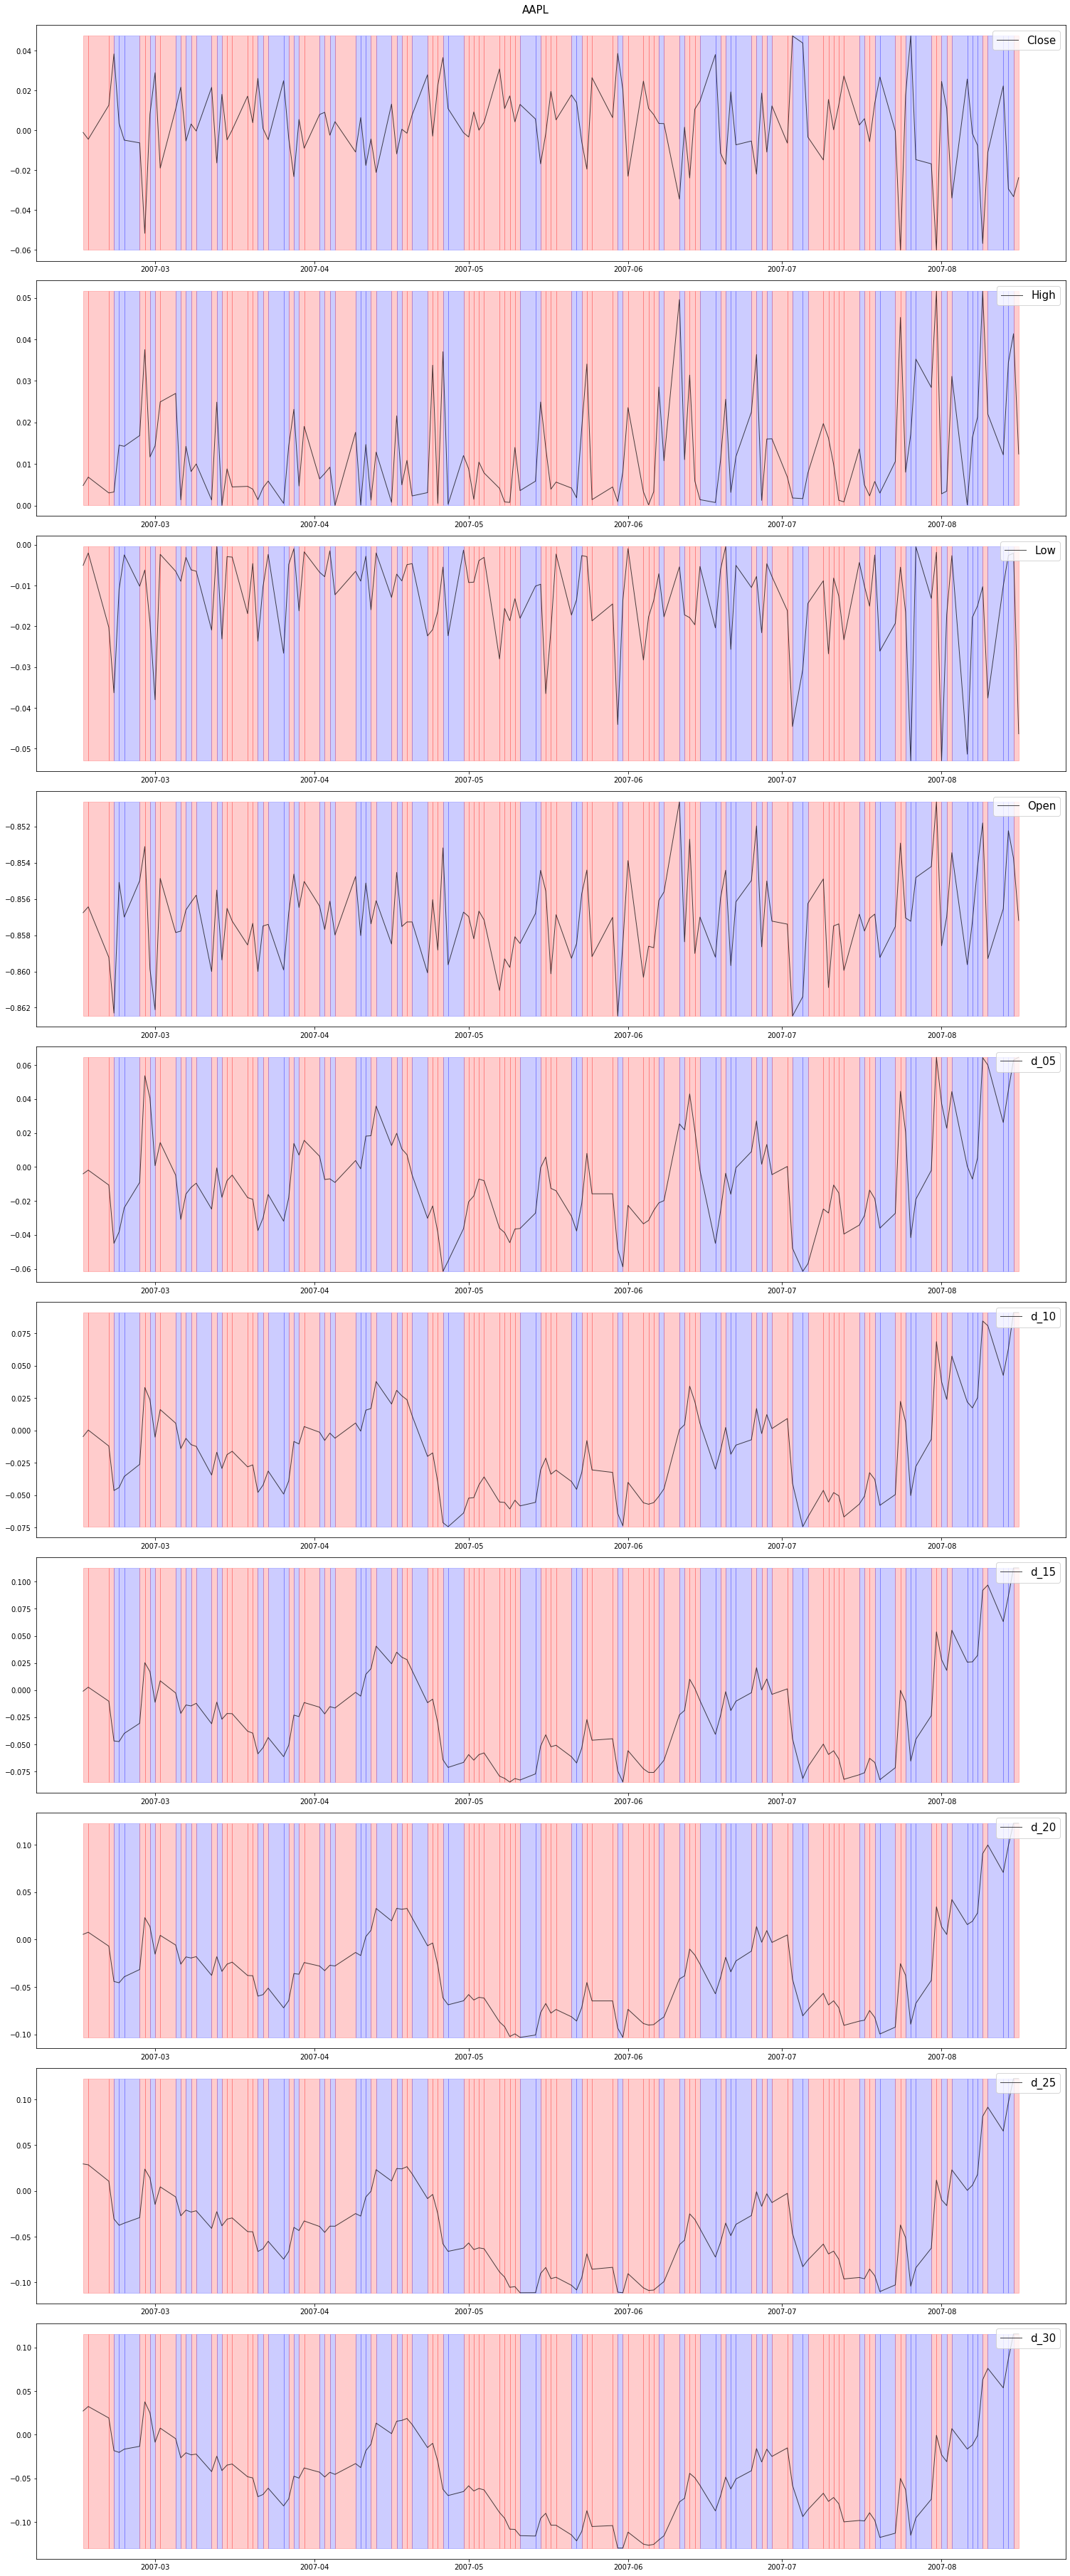

In [18]:
# Stock Index
stock_idx = 0

raw_data = pd.read_csv(stock_dir_list[stock_idx], usecols=['Date','High','Low','Open','Close','Volume','Adj Close'])
raw_data['Date'] = pd.to_datetime(raw_data['Date'])
raw_data = raw_data.sort_values('Date').reset_index(drop = True)

ana_data = raw_data.copy()

del ana_data['Volume']

ana_data['Open'] = ana_data['Open']/ana_data['Close'] - 1
ana_data['High'] = ana_data['High']/ana_data['Close'] - 1
ana_data['Low'] = ana_data['Low']/ana_data['Close'] - 1
ana_data['Close'] = ana_data['Close'].pct_change()
ana_data['d_05'] = ana_data['Adj Close'].shift(1).rolling(5).sum()/(ana_data['Adj Close'] * 5) - 1
ana_data['d_10'] = ana_data['Adj Close'].shift(1).rolling(10).sum()/(ana_data['Adj Close'] * 10) - 1
ana_data['d_15'] = ana_data['Adj Close'].shift(1).rolling(15).sum()/(ana_data['Adj Close'] * 15) - 1
ana_data['d_20'] = ana_data['Adj Close'].shift(1).rolling(20).sum()/(ana_data['Adj Close'] * 20) - 1
ana_data['d_25'] = ana_data['Adj Close'].shift(1).rolling(25).sum()/(ana_data['Adj Close'] * 25) - 1
ana_data['d_30'] = ana_data['Adj Close'].shift(1).rolling(30).sum()/(ana_data['Adj Close'] * 30) - 1
ana_data['Adj Close'] = ana_data['Adj Close'].pct_change()  # 순서 바꾸면 안됨.
ana_data['target'] = ana_data["Adj Close"].shift(-1) > 0
ana_data['target'] = ana_data['target'].astype(int)


ana_data = ana_data.dropna().reset_index(drop = True)
ana_data = ana_data.loc[ana_data['Date'] <= pd.date_range(ana_data['Date'][0],periods=2, freq='130B')[1]]

x_col_names = list(set(ana_data.columns) - set(['Date','Adj Close','target']))
x_col_names.sort()

fig, ax = plt.subplots(len(x_col_names),1,figsize=(21, 50))

for idx in range(len(x_col_names)) :
    
    y = ana_data[x_col_names[idx]].copy()
    qnt_001 = y.quantile(0.01)
    qnt_099 = y.quantile(0.99)

    y[y<=qnt_001] = qnt_001
    y[y>=qnt_099] = qnt_099

    ax[idx].plot(ana_data['Date'], y, label = x_col_names[idx], linewidth = 1, color = 'black', alpha = 0.7)

    y1 = y.min()
    y2 = y.max()

    for iidx in range(1,len(ana_data)):
    # for iidx in range(1,1429):    
        target = ana_data.iloc[(iidx-1):(iidx+1)]['target'].values[-1]
        ax[idx].fill_between(x = ana_data.iloc[(iidx-1):(iidx+1)]['Date'].values, y1 = y1, y2 = y2, color = 'red' if target == 1 else 'blue', alpha = 0.2)

    # ax[idx].axvline(pd.to_datetime('2015-01-01'),linestyle = '--')
    # ax[idx].axvline(pd.to_datetime('2016-01-01'),linestyle = '--', color = 'red')
    ax[idx].legend(fontsize = 15, loc = 'upper right')
fig.suptitle(stock_labels[stock_idx], fontsize = 15, position = (0.5,1.005))
fig.tight_layout()

In [19]:
train_y_list = []
for train_idx in range(len(Model_Y_TRAIN[0])):
    train_y_list.append(np.array([Model_Y_TRAIN[s][train_idx] for s in range(len(Model_Y_TRAIN))]))

train_y = np.array(train_y_list)    


valid_y_list = []
for valid_idx in range(len(Model_Y_VALID[0])):
    valid_y_list.append(np.array([Model_Y_VALID[s][valid_idx] for s in range(len(Model_Y_VALID))]))    
    
valid_y = np.array(valid_y_list)   


test_y_list = []
for test_idx in range(len(Model_Y_TEST[0])):
    test_y_list.append(np.array([Model_Y_TEST[s][test_idx] for s in range(len(Model_Y_TEST))]))    
    
test_y = np.array(test_y_list) 

In [20]:
############################################
# Model build
############################################

# model Build
smc_model_list = []
for params_idx, params in tune_grid.iterrows():
#     if params_idx >= 1 :
#         break

    print(f'params_idx : [{params_idx}] Model build complete')
    smc_model_list.append(
        model(params['nStocks'],params['nTimeSteps'],params['nFeatures'],params['bFeatureTransShare'],params['nFeatureTransUnits']
             ,params['bUseInitialState'],params['nGruHiddenUnits'],params['bHiddenConcat'],params['nMcBeta'],params['nMultiHeads']
             ,params['bAddContextLayer'],params['nMlpMultiples'],params['bLayerNormal'],params['nDropOutRate'],params['nRegularizers']
             ,params['sOptimizer'],params['nLearningRate'],params['bTimeDistributed'])
    )
    


params_idx : [0] Model build complete
params_idx : [1] Model build complete
params_idx : [2] Model build complete


In [21]:
# for mdl_idx in range(len(smc_model_list)) :
#     tf.keras.utils.plot_model(smc_model_list[mdl_idx].smc_model, to_file=f'dtml_model_plot_{str(mdl_idx).zfill(2)}.png', show_shapes=True, show_layer_names=True,show_layer_activations=True)

In [22]:
# smc_model_list[0].smc_model.summary()
# tf.keras.utils.plot_model(smc_model_list[0].smc_model, to_file=f'dtml_model_plot_{str(0).zfill(2)}.png', show_shapes=True, show_layer_names=True,show_layer_activations=True)

In [23]:
# model fitting
train_loss = []
valid_loss = []
for model_idx in range(len(smc_model_list)):
    print(f'=========================================================')
    print(f'model_idx : [{model_idx}] Model fitting start')
    print(f'=========================================================')
    
    
    # Early Stopping, Reduce Learning Rate, HIstory
    EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = tune_grid.iloc[model_idx]['nPatience'], restore_best_weights=True, verbose = 0) 
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss', mode = 'min', factor=0.5, patience=5, verbose=0, min_lr=1e-5)
    history = tf.keras.callbacks.History()
    
#     EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience = tune_grid.iloc[model_idx]['nPatience'], restore_best_weights=True, verbose = 0) 
#     reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', factor=0.5, patience=10, verbose=0, min_lr=1e-5)
#     history = tf.keras.callbacks.History()
    
 
    # Model Save
#     ModelCheck = tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(root_dir,f'/Model/smc_model_v{str(model_idx).zfill(3)}.h5')
#                                                     , monitor = 'val_loss'
#                                                     , mode = 'min'
#                                                     , save_best_only = True)
    
    smc_model_list[model_idx].smc_model.fit(X_TRAIN, train_y, validation_data=(X_VALID, valid_y)
                                            , epochs = tune_grid.iloc[model_idx]['nMaxEpoch']
                                            , batch_size = tune_grid.iloc[model_idx]['nBatchSize']
                                            , callbacks = [PrinterCallback(),EarlyStopping, reduce_lr,history]
                                            , verbose = 0
                                           )
    
    train_loss.append(smc_model_list[model_idx].smc_model.history.history['loss'])
    valid_loss.append(smc_model_list[model_idx].smc_model.history.history['val_loss'])

model_idx : [0] Model fitting start
--------------------------------------------------
STARTING EPOCH: 0 / Learning Rate: 0.001
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
EPOCH: 0, Train Loss: 1.1903, Train Acc: 0.5023, Val Loss: 0.8256, 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
EPOCH: 0, Train Loss: 1.1424, Train Acc: 0.5041, Val Loss: 0.8074, Val Acc: 0.5017
--------------------------------------------------
STARTING EPOCH: 1 / Learning Rate: 0.001
EPOCH: 1, Train Loss: 0.7410, Train Acc: 0.5092, Val Loss: 0.7071, Val Acc: 0.5065
--------------------------------------------------
STARTING EPOCH: 2 / Learning Rate: 0.001
EPOCH: 2, Train Loss: 0.6990

### 결과 저장

In [24]:
# Summary 테이블 생성
summary_model_result = tune_grid.iloc[range(len(smc_model_list))].copy()

# # result summary save
# summary_model_result['val_loss'] = [np.array(valid_loss[s]).min() for s in range(len(valid_loss))]

In [25]:
# Accuracy 생성
train_acc, valid_acc, test_acc, total_acc = [], [], [], []

# Sen
train_sen, valid_sen, test_sen, total_sen = [], [], [], []

# Spc
train_spc, valid_spc, test_spc, total_spc = [], [], [], []

# Mcc
train_mcc, valid_mcc, test_mcc, total_mcc = [], [], [], []

# Model 별로 Accuracy 생성
for model_idx in range(len(smc_model_list)):
    train_pred = smc_model_list[model_idx].smc_model.predict(X_TRAIN)
    valid_pred = smc_model_list[model_idx].smc_model.predict(X_VALID)
    test_pred  = smc_model_list[model_idx].smc_model.predict(X_TEST)

    
    # 각 주식별로 ACCURACY 생성
    train_acc_list, valid_acc_list, test_acc_list = [], [], []
    
    train_sen_list, valid_sen_list, test_sen_list = [], [], []
    
    train_spc_list, valid_spc_list, test_spc_list = [], [], []
    
    train_mcc_list, valid_mcc_list, test_mcc_list = [], [], []


    # 해당 모델별로 주식1 ~ 주식10 까지의 Total ACC, SEN, SPC 계산을 위한 코드 Start ========================================
    # 각 주식별로 for 루프 진행, len(train_pred) == nStocks
    for idx in range(train_pred.shape[1]) :
        true_train = train_y[:,idx,:]
        true_valid = valid_y[:,idx,:]
        true_test  = test_y[:,idx,:]
        
        pred_train = np.where(train_pred[:,idx,:] > 0.5 ,1 ,0)
        pred_valid = np.where(valid_pred[:,idx,:] > 0.5 ,1 ,0)
        pred_test  = np.where(test_pred[:,idx,:] > 0.5 ,1 ,0)
        
        # acc
        tr_acc = (true_train == pred_train).mean()
        vd_acc = (true_valid == pred_valid).mean()
        te_acc = (true_test == pred_test).mean()
        
        train_acc_list.append(tr_acc); valid_acc_list.append(vd_acc); test_acc_list.append(te_acc)
        
        # sen
        tr_sen = (pred_train[true_train==1] == 1).mean()
        vd_sen = (pred_valid[true_valid==1] == 1).mean()
        te_sen = (pred_test[true_test==1] == 1).mean()
        
        train_sen_list.append(tr_sen); valid_sen_list.append(vd_sen); test_sen_list.append(te_sen)
        
        # spc
        tr_spc = (pred_train[true_train==0] == 0).mean()
        vd_spc = (pred_valid[true_valid==0] == 0).mean()
        te_spc = (pred_test[true_test==0] == 0).mean()
        
        train_spc_list.append(tr_spc); valid_spc_list.append(vd_spc); test_spc_list.append(te_spc)
        
        # mcc
        tr_mcc = matthews_corrcoef(true_train.reshape(-1),pred_train.reshape(-1))
        vd_mcc = matthews_corrcoef(true_valid.reshape(-1),pred_valid.reshape(-1))
        te_mcc = matthews_corrcoef(true_test.reshape(-1),pred_test.reshape(-1))
        
        train_mcc_list.append(tr_mcc); valid_mcc_list.append(vd_mcc); test_mcc_list.append(te_mcc)
    # 해당 모델별로 주식1 ~ 주식10 까지의 Total ACC, SEN, SPC 계산을 위한 코드 End ==========================================    
        
    
    # 각 모델별 Total ACC, SEN, SPC PRINT를 위한 코드 Start ========================================
    total_tr_acc = round(np.array(train_acc_list).mean()*100,2)
    total_vd_acc = round(np.array(valid_acc_list).mean()*100,2)
    total_te_acc = round(np.array(test_acc_list).mean()*100,2)
    
    total_tr_sen = round(np.array(train_sen_list).mean()*100,2)
    total_vd_sen = round(np.array(valid_sen_list).mean()*100,2)
    total_te_sen = round(np.array(test_sen_list).mean()*100,2)
    
    total_tr_spc = round(np.array(train_spc_list).mean()*100,2)
    total_vd_spc = round(np.array(valid_spc_list).mean()*100,2)
    total_te_spc = round(np.array(test_spc_list).mean()*100,2)
    
    total_tr_mcc = round(np.array(train_mcc_list).mean()*100,2)
    total_vd_mcc = round(np.array(valid_mcc_list).mean()*100,2)
    total_te_mcc = round(np.array(test_mcc_list).mean()*100,2)
    
    print(f'model_idx [{str(model_idx).zfill(3)}] / train acc : {total_tr_acc}% / valid acc : {total_vd_acc}% / test acc : {total_te_acc}%')
    print(f'model_idx [{str(model_idx).zfill(3)}] / train sen : {total_tr_sen}% / valid sen : {total_vd_sen}% / test sen : {total_te_sen}%')
    print(f'model_idx [{str(model_idx).zfill(3)}] / train spc : {total_tr_spc}% / valid spc : {total_vd_spc}% / test spc : {total_te_spc}%')
    print(f'model_idx [{str(model_idx).zfill(3)}] / train mcc : {total_tr_mcc}% / valid mcc : {total_vd_mcc}% / test mcc : {total_te_mcc}%')
    # 각 모델별 Total ACC, SEN, SPC PRINT를 위한 코드 End ==========================================
    
    
    
    # 각 모델별, 주식별 ACC, SEN, SPC 저장을 위한 코드 Start =======================================
    train_acc.append(np.array(train_acc_list)); valid_acc.append(np.array(valid_acc_list)); test_acc.append(np.array(test_acc_list))
    total_acc.append(np.array([total_tr_acc,total_vd_acc,total_te_acc]))
    
    train_sen.append(np.array(train_sen_list)); valid_sen.append(np.array(valid_sen_list)); test_sen.append(np.array(test_sen_list))
    total_sen.append(np.array([total_tr_sen,total_vd_sen,total_te_sen]))
    
    train_spc.append(np.array(train_spc_list)); valid_spc.append(np.array(valid_spc_list)); test_spc.append(np.array(test_spc_list))
    total_spc.append(np.array([total_tr_spc,total_vd_spc,total_te_spc]))
    
    train_mcc.append(np.array(train_mcc_list)); valid_mcc.append(np.array(valid_mcc_list)); test_mcc.append(np.array(test_mcc_list))
    total_mcc.append(np.array([total_tr_mcc,total_vd_mcc,total_te_mcc]))
    
    # 각 모델별, 주식별 ACC, SEN, SPC 저장을 위한 코드 End =========================================
    

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
8/8 [==============================] - 1s 83ms/step
model_idx [000] / train acc : 55.05% / valid acc : 51.07% / test acc : 51.78%
model_idx [000] / train sen : 56.74% / valid sen : 69.45% / test sen : 52.13%
model_idx [000] / train spc : 52.43% / valid spc : 33.21% / test spc : 50.78%
model_idx [000] / train mcc : 9.81% / valid mcc : 3.01% / test mcc : 3.01%
Please report thi

In [26]:
# accuracy
total_acc_df = pd.DataFrame(total_acc, columns = ['train_total_acc','valid_total_acc','test_total_acc'])
train_acc_df = pd.DataFrame(train_acc, columns = [f'train_acc_{s}' for s in range(len(train_pred[0]))])
valid_acc_df = pd.DataFrame(valid_acc, columns = [f'valid_acc_{s}' for s in range(len(train_pred[0]))])
test_acc_df  = pd.DataFrame(test_acc,  columns = [f'test_acc_{s}'  for s in range(len(train_pred[0]))])

#  sen
total_sen_df = pd.DataFrame(total_sen, columns = ['train_total_sen','valid_total_sen','test_total_sen'])
train_sen_df = pd.DataFrame(train_sen, columns = [f'train_sen_{s}' for s in range(len(train_pred[0]))])
valid_sen_df = pd.DataFrame(valid_sen, columns = [f'valid_sen_{s}' for s in range(len(train_pred[0]))])
test_sen_df  = pd.DataFrame(test_sen,  columns = [f'test_sen_{s}'  for s in range(len(train_pred[0]))])

# spc
total_spc_df = pd.DataFrame(total_spc, columns = ['train_total_spc','valid_total_spc','test_total_spc'])
train_spc_df = pd.DataFrame(train_spc, columns = [f'train_spc_{s}' for s in range(len(train_pred[0]))])
valid_spc_df = pd.DataFrame(valid_spc, columns = [f'valid_spc_{s}' for s in range(len(train_pred[0]))])
test_spc_df  = pd.DataFrame(test_spc,  columns = [f'test_spc_{s}'  for s in range(len(train_pred[0]))])


# concat
final_result_df = pd.concat([summary_model_result,total_acc_df,total_sen_df,total_spc_df,train_acc_df,train_sen_df,train_spc_df,
                             valid_acc_df,valid_sen_df,valid_spc_df,test_acc_df,test_sen_df,test_spc_df],axis = 1)

# Transpose
final_result_df = final_result_df.T.set_axis([f'Model_{s}' for s in range(len(smc_model_list))], axis=1, inplace=False)

# save
final_result_df.to_csv(os.path.join(root_dir,'OUT/tune_result_df.csv'),index = True,encoding="utf-8-sig")

### Test Pred Graph
```
명암 - 붉은색(실제 상승), 푸른색(실제 하락)
실선 - 붉은색(예측 확률), 푸른색(0.5)
```

8/8 [==============================] - 1s 72ms/step


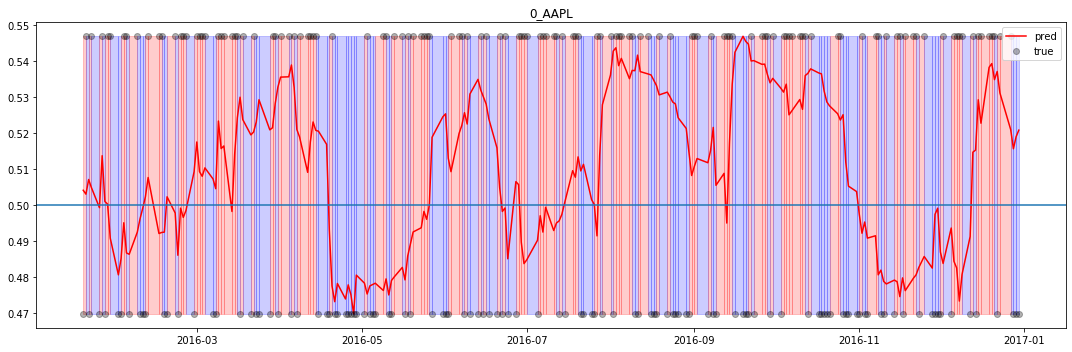

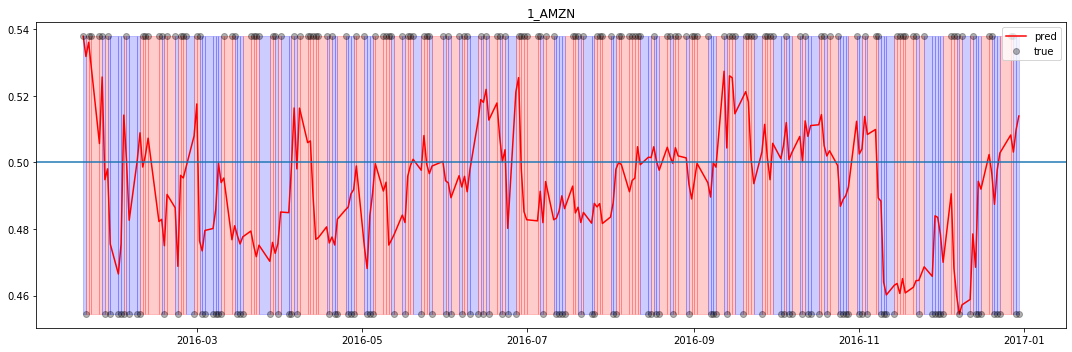

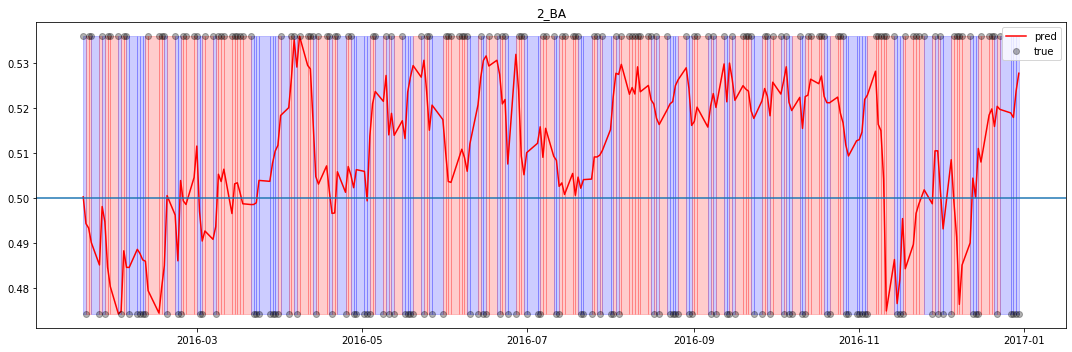

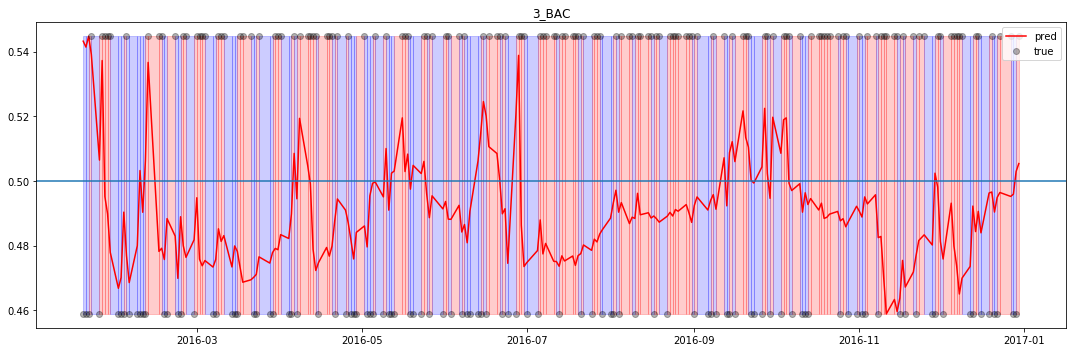

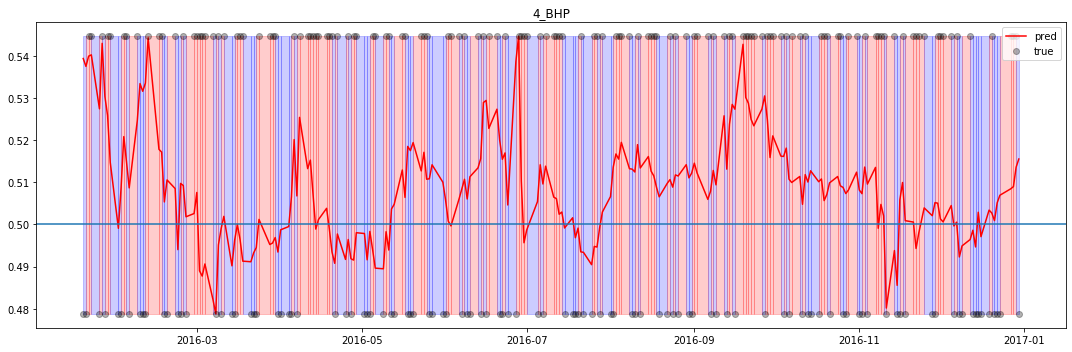

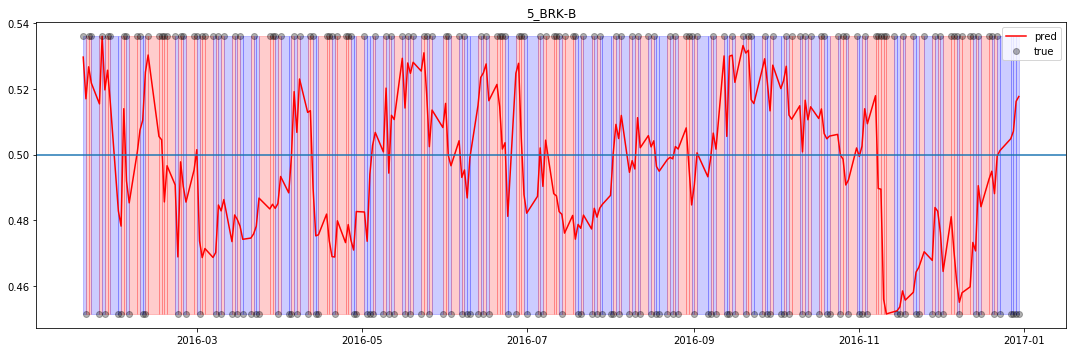

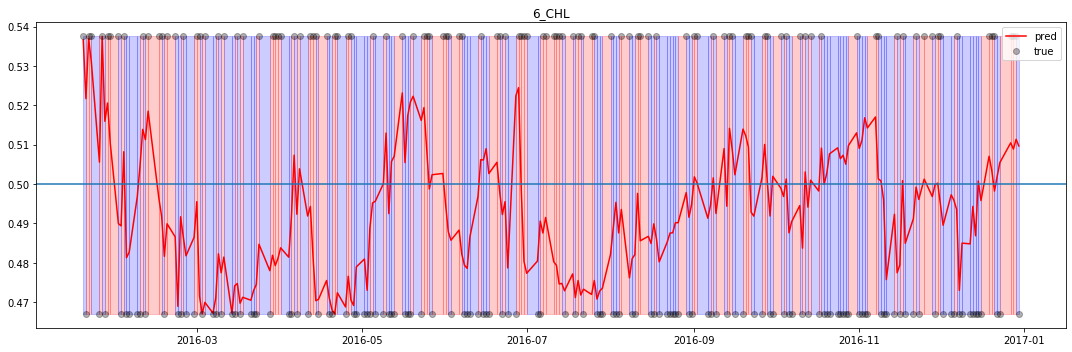

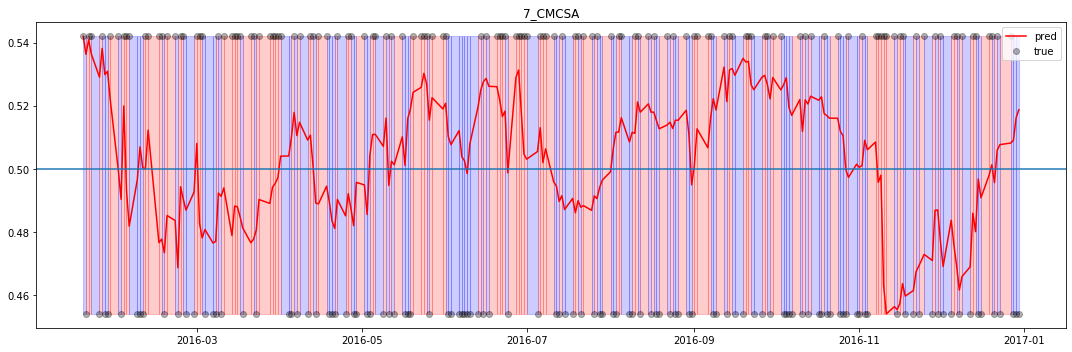

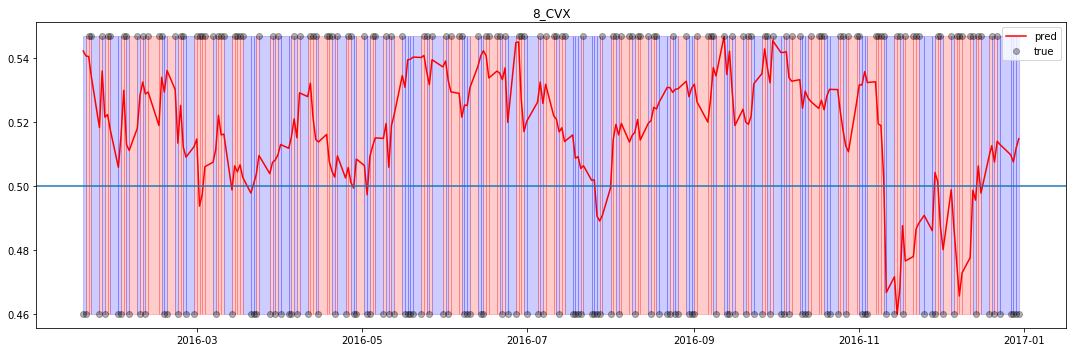

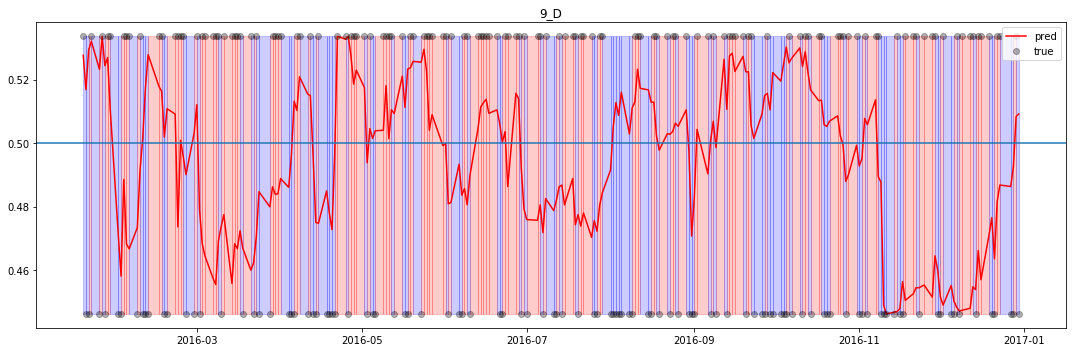

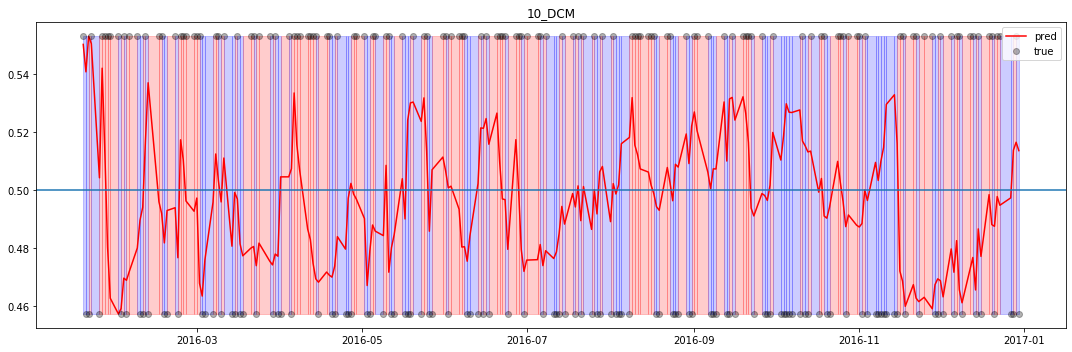

In [38]:
model_idx  = 0
test_pred  = smc_model_list[model_idx].smc_model.predict(X_TEST)

for idx in range(test_pred.shape[1]):
    if idx > 10 :
        continue
        
    # 주식별 x, y 생성
    x_date = ana_data_ts.Date.values[10:].reshape(-1)
    tmp_pred = test_pred[:,idx,:].reshape(-1)
    tmp_true = np.where(test_y[:,idx,:] == 1, test_pred[:,idx,:].max(),test_pred[:,idx,:].min()).reshape(-1)
    
    # Plot
    fig, ax = plt.subplots(1,1,figsize = (15,5))
    # pred line plot
    sns.lineplot(x = x_date,y=tmp_pred, label = 'pred', color = 'red')
    # true plot
    ax.plot(x_date,tmp_true, label = 'true', marker='o',linestyle = '', color = 'black', alpha = 0.3)
    
    # 상승하락 영역 채우기
    value_for_fill_df = pd.DataFrame({"value" : test_y[:,idx,:].reshape(-1)})
    
    for iidx in range(1,len(value_for_fill_df)) :
        ttmp = value_for_fill_df.iloc[(iidx-1):(iidx+1)]
        ax.fill_between(x_date[(iidx-1):(iidx+1)],y1 = tmp_true.min(), y2 = tmp_true.max(), alpha=0.2, color = np.where(ttmp['value'].values[-1] > 0 , 'red', 'blue').tolist())
#     plt.xlim(pd.to_datetime('2016-11-01'),pd.to_datetime('2016-11-30'))

    ax.axhline(0.5)
    ax.set_title(f'{idx}_{stock_labels[idx]}')
    ax.legend(loc = 'upper right')
    fig.tight_layout()
    plt.show()

### Get Temporal Attention , Stock Attention Map

In [81]:
model_idx = 0

In [49]:
# smc_model_list[model_idx].smc_model.summary()

In [82]:
temporal_attention_layer_idx = [s for s in range(len(smc_model_list[model_idx].smc_model.layers)) if 'th_attention_reshape' in smc_model_list[model_idx].smc_model.layers[s].name]
multi_head_attention_layer_idx = [s for s in range(len(smc_model_list[model_idx].smc_model.layers)) if 'multi_head_attention' in smc_model_list[model_idx].smc_model.layers[s].name]

In [83]:
market_input_layer_idx = [s for s in range(len(smc_model_list[model_idx].smc_model.layers)) if 'market_input' in smc_model_list[model_idx].smc_model.layers[s].name]
stock_input_layer_idx = [s for s in range(len(smc_model_list[model_idx].smc_model.layers)) if 'stock_input' in smc_model_list[model_idx].smc_model.layers[s].name]
input_layer_idx = market_input_layer_idx + stock_input_layer_idx

In [84]:
# ===================================================================================================================
# Sub Model Input Layer
# ===================================================================================================================
sub_model_inputs = [smc_model_list[model_idx].smc_model.layers[s].input for s in input_layer_idx]

In [89]:
# ===================================================================================================================
# Temporal Attention
# ===================================================================================================================
temporal_attention_outputs = [smc_model_list[model_idx].smc_model.layers[s].output for s in temporal_attention_layer_idx]
temporal_attention_model = tf.keras.Model(inputs = sub_model_inputs, outputs = temporal_attention_outputs)
temporal_attention_result = temporal_attention_model.predict([X_TEST[s][0:1,:,:]  for s in range(len(X_TEST))]) # X_Test 날짜

# attention result data frame
temporal_attention_result_df = pd.DataFrame(np.array(temporal_attention_result).reshape(nStocks,window_size)) # nStocks, window_size
temporal_attention_result_df.style.background_gradient(cmap='RdYlGn',axis=1)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 16s 16s/step


,0,1,2,3,4,5,6,7,8,9
0,0.095671,0.097534,0.099077,0.101168,0.101914,0.101634,0.100883,0.101171,0.100368,0.100579
1,0.095225,0.096668,0.097644,0.100061,0.100943,0.100231,0.099858,0.102553,0.102395,0.104420
2,0.095768,0.096312,0.097146,0.099037,0.100867,0.101710,0.101553,0.102312,0.102229,0.103065
3,0.097306,0.097651,0.098612,0.100039,0.100952,0.100487,0.100499,0.101492,0.100927,0.102035
4,0.081022,0.081966,0.087860,0.096124,0.102030,0.107006,0.112578,0.115167,0.106387,0.109861
5,0.099533,0.099674,0.099749,0.099916,0.100082,0.100125,0.100109,0.100312,0.100217,0.100283
6,0.095842,0.097371,0.099081,0.100911,0.101634,0.101681,0.101398,0.101104,0.100218,0.100760
7,0.098836,0.099396,0.099806,0.100151,0.100280,0.100315,0.100254,0.100465,0.100209,0.100289
8,0.089584,0.090174,0.092281,0.095919,0.099772,0.103792,0.106276,0.108303,0.107213,0.106687
9,0.099076,0.099497,0.099799,0.099980,0.100206,0.100298,0.100290,0.100266,0.100327,0.100261


In [85]:
# ===================================================================================================================
# Multi Head Attention
# ===================================================================================================================
multi_head_attention_model = tf.keras.Model(inputs = sub_model_inputs, outputs = smc_model_list[model_idx].smc_model.layers[multi_head_attention_layer_idx[0]].output)

# predict attention map
_, attention_map = multi_head_attention_model.predict([X_TEST[s][0:1,:,:]  for s in range(len(X_TEST))])
attention_map_result_array = (np.mean(attention_map.reshape(attention_map.shape[1],nStocks,nStocks),axis = 0))

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1/1 [==============================] - 18s 18s/step


In [86]:
sort_idx = np.argsort(attention_map_result_array.sum(axis = 0))[::-1]

In [87]:
attention_map_result_df = pd.DataFrame(attention_map_result_array,columns = stock_labels, index = stock_labels).iloc[sort_idx,sort_idx]

In [88]:
attention_map_result_df.style.background_gradient(cmap='RdYlGn',axis=1)

,PTR,BHP,WFC,DOW,BAC,AAPL,JPM,CVX,AMZN,SYT,RIO,EXC,GE,XOM,D,NGG,MO,HD,DCM,DUK,PG,NTT,VZ,UPS,GOOGL,TOT,RDS-B,SO,PFE,BRK-B,MSFT,INTC,KO,UNH,JNJ,MRK,MMM,PEP,SPY,ORCL,T,WMT,NVS,VALE,DIS,CMCSA,TM,MA,CHL,BA
PTR,0.121006,0.026669,0.079441,0.029269,0.022532,0.011272,0.029206,0.010473,0.039597,0.027834,0.015988,0.020076,0.018934,0.016015,0.017363,0.021280,0.018119,0.018314,0.015810,0.016240,0.015416,0.015548,0.016848,0.020562,0.013668,0.015184,0.014695,0.015505,0.014417,0.015788,0.015421,0.012668,0.016097,0.015794,0.014720,0.013692,0.014035,0.014800,0.014349,0.012128,0.013918,0.014059,0.012101,0.008871,0.012599,0.014119,0.010480,0.012181,0.013607,0.011293
BHP,0.172841,0.011683,0.094932,0.009336,0.064980,0.018836,0.015565,0.058828,0.011010,0.020665,0.029522,0.014563,0.015571,0.011834,0.012570,0.013154,0.012254,0.014783,0.013023,0.012202,0.012658,0.012283,0.012530,0.014649,0.012253,0.014853,0.015165,0.011772,0.012618,0.012843,0.013801,0.011841,0.012084,0.011870,0.011573,0.012335,0.011591,0.012025,0.012336,0.010319,0.010914,0.011247,0.009189,0.020389,0.011311,0.011402,0.015880,0.008521,0.011618,0.009981
WFC,0.066426,0.054266,0.035919,0.023531,0.018203,0.018965,0.044870,0.015980,0.026309,0.017304,0.063090,0.016469,0.018726,0.017794,0.019824,0.017062,0.016623,0.016857,0.014709,0.016309,0.015908,0.014811,0.017548,0.017905,0.016046,0.014812,0.013612,0.015476,0.015549,0.016091,0.014555,0.014734,0.016269,0.016615,0.016351,0.015377,0.016136,0.015066,0.015547,0.015533,0.015214,0.014817,0.014586,0.014367,0.017764,0.014979,0.013139,0.014954,0.014142,0.012864
DOW,0.151421,0.125935,0.014483,0.007824,0.034382,0.082392,0.006792,0.130037,0.014555,0.008414,0.016404,0.008145,0.009187,0.008230,0.008040,0.007627,0.007683,0.009292,0.009669,0.008548,0.008947,0.008435,0.007886,0.008066,0.010289,0.010388,0.013405,0.008593,0.009642,0.008733,0.010243,0.010502,0.008165,0.007969,0.008157,0.010227,0.010046,0.009248,0.010761,0.009044,0.009196,0.009016,0.009946,0.030515,0.009660,0.009982,0.020352,0.010172,0.016001,0.017351
BAC,0.068540,0.026237,0.047240,0.018859,0.033248,0.023406,0.033624,0.011829,0.022677,0.020904,0.015331,0.019362,0.021366,0.017543,0.020208,0.017380,0.018513,0.019114,0.016866,0.017972,0.017437,0.017320,0.019395,0.019284,0.016910,0.017613,0.016273,0.017251,0.017747,0.017607,0.016245,0.017463,0.017291,0.017618,0.018261,0.017189,0.018454,0.017566,0.017575,0.016052,0.016752,0.016286,0.016134,0.014510,0.017281,0.016086,0.016243,0.014829,0.016255,0.014857
AAPL,0.020848,0.023409,0.025130,0.020509,0.033148,0.023235,0.024219,0.016378,0.022509,0.020374,0.022291,0.019688,0.022279,0.019304,0.021083,0.018843,0.019723,0.020103,0.017811,0.019054,0.019180,0.018554,0.021335,0.021022,0.018451,0.019353,0.018711,0.018559,0.019340,0.019124,0.017644,0.019265,0.018983,0.019801,0.020517,0.018899,0.019957,0.018793,0.020649,0.018818,0.018994,0.018039,0.018029,0.017112,0.020340,0.018330,0.018668,0.017825,0.017942,0.017826
JPM,0.019415,0.038393,0.014239,0.044145,0.014612,0.017110,0.024178,0.041627,0.018401,0.017423,0.031270,0.018835,0.018242,0.019808,0.019780,0.019553,0.018577,0.018455,0.018016,0.018844,0.018515,0.018317,0.018554,0.018912,0.018132,0.017353,0.019815,0.018476,0.018299,0.018170,0.017865,0.016725,0.018600,0.020084,0.019361,0.018698,0.017878,0.017482,0.018123,0.019173,0.019012,0.018467,0.019659,0.019050,0.018739,0.018584,0.015216,0.019775,0.016679,0.015363
CVX,0.144886,0.066267,0.060429,0.051596,0.058784,0.009296,0.069162,0.007766,0.070796,0.035846,0.006905,0.019258,0.014739,0.012772,0.013754,0.016265,0.015419,0.013067,0.011936,0.012138,0.011923,0.012918,0.013096,0.013676,0.010473,0.011186,0.011137,0.011142,0.010425,0.010770,0.011092,0.009402,0.011388,0.010230,0.010667,0.009364,0.008933,0.009541,0.008558,0.009805,0.008951,0.009217,0.008281,0.005075,0.007961,0.008350,0.006486,0.006804,0.006931,0.005138
AMZN,0.089215,0.046279,0.016333,0.015264,0.071581,0.042367,0.021193,0.028764,0.030406,0.020485,0.033414,0.018028,0.019781,0.017132,0.016330,0.013310,0.015151,0.015889